In [9]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# 데이터 로드
url = "https://raw.githubusercontent.com/MyungKyuYi/AI-class/refs/heads/main/diabetes.csv"
df = pd.read_csv(url)
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [10]:
df.drop(columns=["Outcome"], inplace=True)
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33
...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63
764,2,122,70,27,0,36.8,0.340,27
765,5,121,72,23,112,26.2,0.245,30
766,1,126,60,0,0,30.1,0.349,47


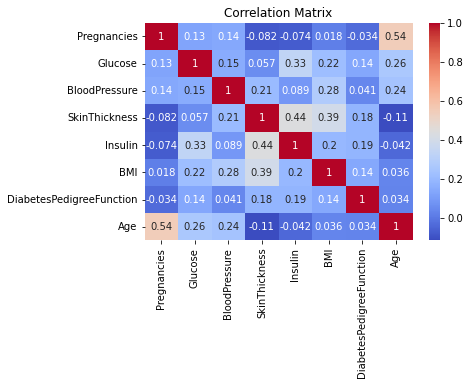

In [11]:
import seaborn as sns
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

In [12]:
df.drop(columns=["Age", "Pregnancies"], inplace=True) #BMI와 상관계수가 너무 적은 컬럼들도 삭제
df

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction
0,148,72,35,0,33.6,0.627
1,85,66,29,0,26.6,0.351
2,183,64,0,0,23.3,0.672
3,89,66,23,94,28.1,0.167
4,137,40,35,168,43.1,2.288
...,...,...,...,...,...,...
763,101,76,48,180,32.9,0.171
764,122,70,27,0,36.8,0.340
765,121,72,23,112,26.2,0.245
766,126,60,0,0,30.1,0.349


Text(0.5, 1.0, 'BMI Outlier Check')

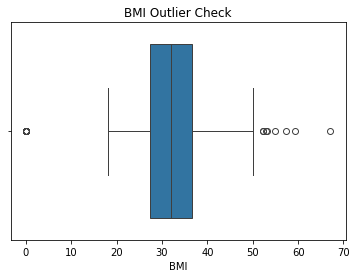

In [13]:
sns.boxplot(x=df['BMI'])
plt.title('BMI Outlier Check')

In [14]:
Q1 = df['BMI'].quantile(0.25)
Q3 = df['BMI'].quantile(0.75)
IQR = Q3 - Q1

# 이상치 범위 지정
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 이상치 제거
df_clean = df[(df['BMI'] >= lower_bound) & (df['BMI'] <= upper_bound)]


Text(0.5, 1.0, 'BMI Outlier Check')

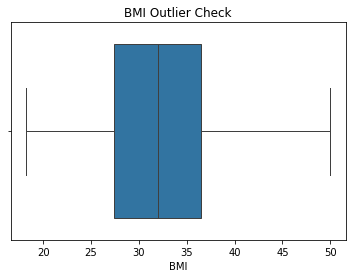

In [15]:
sns.boxplot(x=df_clean['BMI'])
plt.title('BMI Outlier Check')

In [16]:
# 데이터와 타겟 분리
X = df_clean.drop('BMI', axis=1).values
y = df_clean['BMI'].values

In [17]:
# 원-핫 인코딩(이진 분류이므로 생략)
#y = pd.get_dummies(y).values  #=> df일 때때
#y = to_categorical(y) # numpy 배열 일 때

# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

target_scaler = StandardScaler()
y = target_scaler.fit_transform(y.reshape(-1, 1))

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [18]:
# 4. 텐서로 변환
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [19]:
# 5. DataLoader 생성
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [20]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((599, 5), (150, 5), (599, 1), (150, 1))

In [27]:
# 6. 회귀 모델 정의
class RegressionModel(nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(5, 64)
        #self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(64, 32)
        #self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 8)
        self.fc5 = nn.Linear(8, 1) # Output 하나 (로짓)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        #x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        #x = self.dropout2(x)
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x) # sigmoid는 BCEWithLogitsLoss가 내부적으로 처리
        return x

In [28]:
# 7. 디바이스 설정, 모델/손실/옵티마이저 정의
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RegressionModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [29]:
# 8. 학습 루프
model.train()
num_epochs = 50
for epoch in range(num_epochs):
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_loader):.4f}")

Epoch 1/50, Loss: 1.0042
Epoch 2/50, Loss: 0.9580
Epoch 3/50, Loss: 0.8754
Epoch 4/50, Loss: 0.7923
Epoch 5/50, Loss: 0.7574
Epoch 6/50, Loss: 0.7369
Epoch 7/50, Loss: 0.7282
Epoch 8/50, Loss: 0.7101
Epoch 9/50, Loss: 0.6939
Epoch 10/50, Loss: 0.6860
Epoch 11/50, Loss: 0.6756
Epoch 12/50, Loss: 0.6748
Epoch 13/50, Loss: 0.6576
Epoch 14/50, Loss: 0.6502
Epoch 15/50, Loss: 0.6454
Epoch 16/50, Loss: 0.6515
Epoch 17/50, Loss: 0.6358
Epoch 18/50, Loss: 0.6284
Epoch 19/50, Loss: 0.6205
Epoch 20/50, Loss: 0.6168
Epoch 21/50, Loss: 0.6178
Epoch 22/50, Loss: 0.6102
Epoch 23/50, Loss: 0.6077
Epoch 24/50, Loss: 0.6074
Epoch 25/50, Loss: 0.5988
Epoch 26/50, Loss: 0.5924
Epoch 27/50, Loss: 0.6007
Epoch 28/50, Loss: 0.5914
Epoch 29/50, Loss: 0.5924
Epoch 30/50, Loss: 0.5898
Epoch 31/50, Loss: 0.5764
Epoch 32/50, Loss: 0.5813
Epoch 33/50, Loss: 0.5809
Epoch 34/50, Loss: 0.5739
Epoch 35/50, Loss: 0.5725
Epoch 36/50, Loss: 0.5641
Epoch 37/50, Loss: 0.5611
Epoch 38/50, Loss: 0.5588
Epoch 39/50, Loss: 0.

In [30]:
# 평가
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score

model.eval()
preds, actuals = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch).cpu().numpy()
        preds.extend(outputs)
        actuals.extend(y_batch.numpy())

mse = mean_squared_error(actuals, preds)
print(f"Test MSE: {mse:.4f}")

Test MSE: 0.7057


In [31]:
# numpy 변환
preds = np.array(preds)
actuals = np.array(actuals)

# 역변환
preds_original = target_scaler.inverse_transform(preds)
actuals_original = target_scaler.inverse_transform(actuals)

In [32]:
# 성능 지표 계산
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
mse = mean_squared_error(actuals_original, preds_original)
rmse = np.sqrt(mse)
r2 = r2_score(actuals_original, preds_original)

print(f"\n[평가 결과]")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

# 예시: 예측값 5개 출력
print("\n[예측 vs 실제 (일부)]")
for i in range(5):
    print(f"예측: {preds_original[i][0]:.2f}, 실제: {actuals_original[i][0]:.2f}")


[평가 결과]
Mean Squared Error (MSE): 29.6960
Root Mean Squared Error (RMSE): 5.4494
R² Score: 0.3784

[예측 vs 실제 (일부)]
예측: 36.68, 실제: 46.50
예측: 24.91, 실제: 33.70
예측: 28.02, 실제: 26.50
예측: 25.08, 실제: 24.80
예측: 26.80, 실제: 19.50


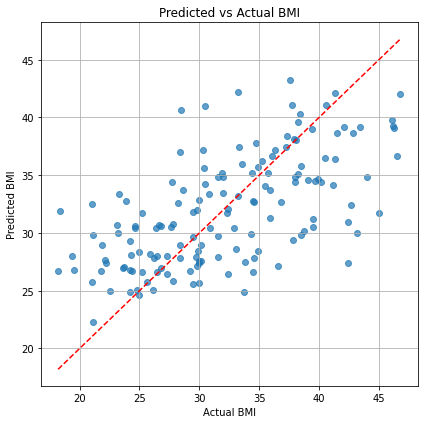

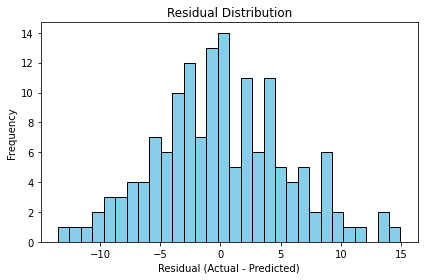

In [33]:
import matplotlib.pyplot as plt

# 1. 예측값 vs 실제값
plt.figure(figsize=(6, 6))
plt.scatter(actuals_original, preds_original, alpha=0.7)
plt.plot([actuals_original.min(), actuals_original.max()],
         [actuals_original.min(), actuals_original.max()], 'r--')
plt.xlabel("Actual BMI")
plt.ylabel("Predicted BMI")
plt.title("Predicted vs Actual BMI")
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Residual Histogram (예측 오차 분포)
residuals = actuals_original - preds_original
plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=30, color='skyblue', edgecolor='black')
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Residual Distribution")
plt.tight_layout()
plt.show()